In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt

from src.deep_learning.vae.vae_datasets import create_data_for_vae
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from collections import defaultdict

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/gr1/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# What data to use
dates = 'all'
colonies = ['l']
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked',]
classes_to_drop = ['weirdo', 'badsplit', 'noise', 'sound']
max_sounds_per_class = {'softchirp': 5000}
#max_sounds_per_class = {}
max_sound_length = 12000
min_sound_length = 1337
min_sound_occurrences = 0
# Denoising parameters
use_rec_denoising = False
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 500, 'time_mask_smooth_ms': 10}
frequency_threshold = 3000
# Sounds metadata parameters
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']
sr = 22050
n_fft = 1024
n_mel = 80
t_dim = 64

In [4]:
recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages, {})

Using 8 recordings


In [15]:
if use_rec_denoising:
    recs_dict = {rec_name: denoise_recording(rec, sr, **rec_denoising_params)
                 for rec_name, rec in recs_dict.items()}

In [19]:
from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata
from src.audiodata_processing.process_waves import butter_highpass_filter


sounds_metadata_train = generate_sounds_metadata(recs_metadata, classes_to_drop, max_sounds_per_class,
                                                 min_sound_length, max_sound_length, columns_to_copy,
                                                 sr=sr, min_sound_occurrences=min_sound_occurrences,
                                                 print_counts=False)
sounds_npy_train = load_sounds(sounds_metadata_train, recs_dict, noisy_sampling=False, timestamps='sec')

sounds_npy_train = np.array([butter_highpass_filter(sound, frequency_threshold, sr) 
                             for sound in sounds_npy_train])

/home/gr1/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


In [60]:
import numpy as np
import warnings
from scipy.signal import stft
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

EPSILON = 1e-12



def create_specs_new(sounds_metadata, recs_dict, p, sr=22050):
    target_freqs = np.linspace(p['min_freq'], p['max_freq'], p['num_freq_bins'])
    specs_new = []
    for s, e, rec_name in sounds_metadata[['s', 'e', 'rec']].values:
        s, e, = int(s * sr), int(e * sr)
        t1, t2 = s/sr, e/sr
        audio = recs_dict[rec_name]
        s1, s2 = int(round(t1*sr)), int(round(t2*sr))
        temp = min(len(audio), s2) - max(0,s1)

        temp_audio = audio[max(0,s1):min(len(audio),s2)]
        temp_audio = temp_audio - np.mean(temp_audio)
        #print('audio', temp_audio.shape)
        f, t, spec = stft(temp_audio, fs=sr, nperseg=p['nperseg'], noverlap=p['noverlap'])
        #print('spec', spec.shape, 't', t.shape)
        t += max(0,t1)
        spec = np.log(np.abs(spec) + EPSILON)
        interp = interp2d(t, f, spec, copy=False, bounds_error=False, fill_value=-1/EPSILON)

        max_dur = 0.2
        duration = t2 - t1
        shoulder = 0.5 * (max_dur - duration)
        target_times = np.linspace(t1-shoulder, t2+shoulder, p['num_time_bins'])
        interp_spec = interp(target_times, target_freqs, assume_sorted=True)

        interp_spec -= p['spec_min_val']
        interp_spec /= (p['spec_max_val'] - p['spec_min_val'])
        interp_spec = np.clip(interp_spec, 0.0, 1.0)
        specs_new.append(np.flip(interp_spec, 0))
    return np.array(specs_new)

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [61]:
from src.audiodata_processing.process_spectrograms import augment_im, resize_with_padding
from src.audiodata_processing.extract_features_from_wave import extract_melspecs


spec_params = {'num_freq_bins': 128,
               'num_time_bins': 128,
               'nperseg': 512, 
               'noverlap': None, 
               'min_freq': 2000,
               'max_freq': 11025,
               'spec_min_val': -10, 
               'spec_max_val': 0,
               'remove_dc_offset': True, 
               'mel': False, 
               'max_dur': 0.4, 
               'time_stretch': True}


specs = create_specs_new(sounds_metadata_train, recs_dict, spec_params, sr=22050)

audio (6086,)
spec (257, 25) t (25,)
audio (4322,)
spec (257, 18) t (18,)
audio (3705,)
spec (257, 16) t (16,)
audio (4410,)
spec (257, 19) t (19,)
audio (4586,)
spec (257, 19) t (19,)
audio (5028,)
spec (257, 21) t (21,)
audio (4763,)
spec (257, 20) t (20,)
audio (4234,)
spec (257, 18) t (18,)
audio (3881,)
spec (257, 17) t (17,)
audio (3176,)
spec (257, 14) t (14,)
audio (5381,)
spec (257, 23) t (23,)
audio (3969,)
spec (257, 17) t (17,)
audio (4763,)
spec (257, 20) t (20,)
audio (5027,)
spec (257, 21) t (21,)
audio (5645,)
spec (257, 24) t (24,)
audio (4851,)
spec (257, 20) t (20,)
audio (4586,)
spec (257, 19) t (19,)
audio (5468,)
spec (257, 23) t (23,)
audio (3881,)
spec (257, 17) t (17,)
audio (5380,)
spec (257, 23) t (23,)
audio (5910,)
spec (257, 25) t (25,)
audio (3616,)
spec (257, 16) t (16,)
audio (4057,)
spec (257, 17) t (17,)
audio (4322,)
spec (257, 18) t (18,)
audio (5645,)
spec (257, 24) t (24,)
audio (5115,)
spec (257, 21) t (21,)
audio (4763,)
spec (257, 20) t (20,)
a

audio (4320,)
spec (257, 18) t (18,)
audio (5467,)
spec (257, 23) t (23,)
audio (5908,)
spec (257, 25) t (25,)
audio (5647,)
spec (257, 24) t (24,)
audio (5645,)
spec (257, 24) t (24,)
audio (4587,)
spec (257, 19) t (19,)
audio (4586,)
spec (257, 19) t (19,)
audio (4587,)
spec (257, 19) t (19,)
audio (4851,)
spec (257, 20) t (20,)
audio (5025,)
spec (257, 21) t (21,)
audio (5556,)
spec (257, 23) t (23,)
audio (5822,)
spec (257, 24) t (24,)
audio (5645,)
spec (257, 24) t (24,)
audio (5469,)
spec (257, 23) t (23,)
audio (5381,)
spec (257, 23) t (23,)
audio (5381,)
spec (257, 23) t (23,)
audio (5203,)
spec (257, 22) t (22,)
audio (4762,)
spec (257, 20) t (20,)
audio (5206,)
spec (257, 22) t (22,)
audio (5819,)
spec (257, 24) t (24,)
audio (4500,)
spec (257, 19) t (19,)
audio (4675,)
spec (257, 20) t (20,)
audio (4586,)
spec (257, 19) t (19,)
audio (5470,)
spec (257, 23) t (23,)
audio (5291,)
spec (257, 22) t (22,)
audio (4234,)
spec (257, 18) t (18,)
audio (7321,)
spec (257, 30) t (30,)
a

audio (4759,)
spec (257, 20) t (20,)
audio (3440,)
spec (257, 15) t (15,)
audio (7058,)
spec (257, 29) t (29,)
audio (4409,)
spec (257, 19) t (19,)
audio (4323,)
spec (257, 18) t (18,)
audio (2907,)
spec (257, 13) t (13,)
audio (4059,)
spec (257, 17) t (17,)
audio (5292,)
spec (257, 22) t (22,)
audio (4495,)
spec (257, 19) t (19,)
audio (4231,)
spec (257, 18) t (18,)
audio (3526,)
spec (257, 15) t (15,)
audio (3612,)
spec (257, 16) t (16,)
audio (5206,)
spec (257, 22) t (22,)
audio (3790,)
spec (257, 16) t (16,)
audio (4409,)
spec (257, 19) t (19,)
audio (4586,)
spec (257, 19) t (19,)
audio (3704,)
spec (257, 16) t (16,)
audio (4053,)
spec (257, 17) t (17,)
audio (5292,)
spec (257, 22) t (22,)
audio (4851,)
spec (257, 20) t (20,)
audio (5028,)
spec (257, 21) t (21,)
audio (4586,)
spec (257, 19) t (19,)
audio (4150,)
spec (257, 18) t (18,)
audio (7412,)
spec (257, 30) t (30,)
audio (4495,)
spec (257, 19) t (19,)
audio (5642,)
spec (257, 24) t (24,)
audio (5206,)
spec (257, 22) t (22,)
a

audio (4500,)
spec (257, 19) t (19,)
audio (7673,)
spec (257, 31) t (31,)
audio (6000,)
spec (257, 25) t (25,)
audio (4940,)
spec (257, 21) t (21,)
audio (4939,)
spec (257, 21) t (21,)
audio (4939,)
spec (257, 21) t (21,)
audio (6612,)
spec (257, 27) t (27,)
audio (4673,)
spec (257, 20) t (20,)
audio (6177,)
spec (257, 26) t (26,)
audio (4319,)
spec (257, 18) t (18,)
audio (6262,)
spec (257, 26) t (26,)
audio (7146,)
spec (257, 29) t (29,)
audio (5732,)
spec (257, 24) t (24,)
audio (5468,)
spec (257, 23) t (23,)
audio (4234,)
spec (257, 18) t (18,)
audio (5029,)
spec (257, 21) t (21,)
audio (5379,)
spec (257, 23) t (23,)
audio (5731,)
spec (257, 24) t (24,)
audio (4762,)
spec (257, 20) t (20,)
audio (4499,)
spec (257, 19) t (19,)
audio (4676,)
spec (257, 20) t (20,)
audio (4147,)
spec (257, 18) t (18,)
audio (4586,)
spec (257, 19) t (19,)
audio (4408,)
spec (257, 19) t (19,)
audio (4501,)
spec (257, 19) t (19,)
audio (3969,)
spec (257, 17) t (17,)
audio (4055,)
spec (257, 17) t (17,)
a

audio (5381,)
spec (257, 23) t (23,)
audio (4761,)
spec (257, 20) t (20,)
audio (6966,)
spec (257, 29) t (29,)
audio (6877,)
spec (257, 28) t (28,)
audio (4409,)
spec (257, 19) t (19,)
audio (4411,)
spec (257, 19) t (19,)
audio (5908,)
spec (257, 25) t (25,)
audio (4586,)
spec (257, 19) t (19,)
audio (4409,)
spec (257, 19) t (19,)
audio (5908,)
spec (257, 25) t (25,)
audio (5028,)
spec (257, 21) t (21,)
audio (5028,)
spec (257, 21) t (21,)
audio (5028,)
spec (257, 21) t (21,)
audio (4497,)
spec (257, 19) t (19,)
audio (4409,)
spec (257, 19) t (19,)
audio (5114,)
spec (257, 21) t (21,)
audio (4942,)
spec (257, 21) t (21,)
audio (6529,)
spec (257, 27) t (27,)
audio (6965,)
spec (257, 29) t (29,)
audio (4060,)
spec (257, 17) t (17,)
audio (4850,)
spec (257, 20) t (20,)
audio (5911,)
spec (257, 25) t (25,)
audio (5910,)
spec (257, 25) t (25,)
audio (5905,)
spec (257, 25) t (25,)
audio (6175,)
spec (257, 26) t (26,)
audio (5642,)
spec (257, 24) t (24,)
audio (5642,)
spec (257, 24) t (24,)
a

spec (257, 21) t (21,)
audio (4409,)
spec (257, 19) t (19,)
audio (6262,)
spec (257, 26) t (26,)
audio (5115,)
spec (257, 21) t (21,)
audio (4673,)
spec (257, 20) t (20,)
audio (5732,)
spec (257, 24) t (24,)
audio (5736,)
spec (257, 24) t (24,)
audio (5733,)
spec (257, 24) t (24,)
audio (5115,)
spec (257, 21) t (21,)
audio (4851,)
spec (257, 20) t (20,)
audio (4675,)
spec (257, 20) t (20,)
audio (5909,)
spec (257, 25) t (25,)
audio (6263,)
spec (257, 26) t (26,)
audio (6880,)
spec (257, 28) t (28,)
audio (4763,)
spec (257, 20) t (20,)
audio (6262,)
spec (257, 26) t (26,)
audio (3353,)
spec (257, 15) t (15,)
audio (5379,)
spec (257, 23) t (23,)
audio (4413,)
spec (257, 19) t (19,)
audio (5117,)
spec (257, 21) t (21,)
audio (5909,)
spec (257, 25) t (25,)
audio (3707,)
spec (257, 16) t (16,)
audio (4677,)
spec (257, 20) t (20,)
audio (5819,)
spec (257, 24) t (24,)
audio (5818,)
spec (257, 24) t (24,)
audio (6966,)
spec (257, 29) t (29,)
audio (4939,)
spec (257, 21) t (21,)
audio (3968,)
s

spec (257, 21) t (21,)
audio (5906,)
spec (257, 25) t (25,)
audio (3709,)
spec (257, 16) t (16,)
audio (3973,)
spec (257, 17) t (17,)
audio (2735,)
spec (257, 12) t (12,)
audio (4678,)
spec (257, 20) t (20,)
audio (4408,)
spec (257, 19) t (19,)
audio (4059,)
spec (257, 17) t (17,)
audio (4856,)
spec (257, 20) t (20,)
audio (4850,)
spec (257, 20) t (20,)
audio (7494,)
spec (257, 31) t (31,)
audio (5028,)
spec (257, 21) t (21,)
audio (4409,)
spec (257, 19) t (19,)
audio (3790,)
spec (257, 16) t (16,)
audio (6438,)
spec (257, 27) t (27,)
audio (5733,)
spec (257, 24) t (24,)
audio (4145,)
spec (257, 18) t (18,)
audio (4501,)
spec (257, 19) t (19,)
audio (3532,)
spec (257, 15) t (15,)
audio (3703,)
spec (257, 16) t (16,)
audio (2643,)
spec (257, 12) t (12,)
audio (5114,)
spec (257, 21) t (21,)
audio (5114,)
spec (257, 21) t (21,)
audio (4409,)
spec (257, 19) t (19,)
audio (7058,)
spec (257, 29) t (29,)
audio (3795,)
spec (257, 16) t (16,)
audio (4415,)
spec (257, 19) t (19,)
audio (4059,)
s

spec (257, 21) t (21,)
audio (5644,)
spec (257, 24) t (24,)
audio (3793,)
spec (257, 16) t (16,)
audio (4499,)
spec (257, 19) t (19,)
audio (3792,)
spec (257, 16) t (16,)
audio (5204,)
spec (257, 22) t (22,)
audio (5116,)
spec (257, 21) t (21,)
audio (6265,)
spec (257, 26) t (26,)
audio (4939,)
spec (257, 21) t (21,)
audio (4852,)
spec (257, 20) t (20,)
audio (5119,)
spec (257, 21) t (21,)
audio (5469,)
spec (257, 23) t (23,)
audio (4587,)
spec (257, 19) t (19,)
audio (4142,)
spec (257, 18) t (18,)
audio (4407,)
spec (257, 19) t (19,)
audio (4589,)
spec (257, 19) t (19,)
audio (2995,)
spec (257, 13) t (13,)
audio (4587,)
spec (257, 19) t (19,)
audio (5557,)
spec (257, 23) t (23,)
audio (5115,)
spec (257, 21) t (21,)
audio (5732,)
spec (257, 24) t (24,)
audio (4939,)
spec (257, 21) t (21,)
audio (5996,)
spec (257, 25) t (25,)
audio (5471,)
spec (257, 23) t (23,)
audio (5291,)
spec (257, 22) t (22,)
audio (5554,)
spec (257, 23) t (23,)
audio (4584,)
spec (257, 19) t (19,)
audio (4146,)
s

spec (257, 15) t (15,)
audio (4764,)
spec (257, 20) t (20,)
audio (2821,)
spec (257, 13) t (13,)
audio (3351,)
spec (257, 15) t (15,)
audio (3263,)
spec (257, 14) t (14,)
audio (3440,)
spec (257, 15) t (15,)
audio (5116,)
spec (257, 21) t (21,)
audio (3793,)
spec (257, 16) t (16,)
audio (4498,)
spec (257, 19) t (19,)
audio (4234,)
spec (257, 18) t (18,)
audio (4939,)
spec (257, 21) t (21,)
audio (4409,)
spec (257, 19) t (19,)
audio (3615,)
spec (257, 16) t (16,)
audio (5733,)
spec (257, 24) t (24,)
audio (3614,)
spec (257, 16) t (16,)
audio (3440,)
spec (257, 15) t (15,)
audio (4323,)
spec (257, 18) t (18,)
audio (3704,)
spec (257, 16) t (16,)
audio (3528,)
spec (257, 15) t (15,)
audio (3970,)
spec (257, 17) t (17,)
audio (3265,)
spec (257, 14) t (14,)
audio (2646,)
spec (257, 12) t (12,)
audio (2912,)
spec (257, 13) t (13,)
audio (3617,)
spec (257, 16) t (16,)
audio (4411,)
spec (257, 19) t (19,)
audio (3529,)
spec (257, 15) t (15,)
audio (2646,)
spec (257, 12) t (12,)
audio (3262,)
s

spec (257, 18) t (18,)
audio (3882,)
spec (257, 17) t (17,)
audio (3967,)
spec (257, 17) t (17,)
audio (4323,)
spec (257, 18) t (18,)
audio (4850,)
spec (257, 20) t (20,)
audio (4850,)
spec (257, 20) t (20,)
audio (2913,)
spec (257, 13) t (13,)
audio (2648,)
spec (257, 12) t (12,)
audio (2648,)
spec (257, 12) t (12,)
audio (3171,)
spec (257, 14) t (14,)
audio (2912,)
spec (257, 13) t (13,)
audio (3526,)
spec (257, 15) t (15,)
audio (3618,)
spec (257, 16) t (16,)
audio (3881,)
spec (257, 17) t (17,)
audio (4587,)
spec (257, 19) t (19,)
audio (4323,)
spec (257, 18) t (18,)
audio (3176,)
spec (257, 14) t (14,)
audio (3526,)
spec (257, 15) t (15,)
audio (3612,)
spec (257, 16) t (16,)
audio (3176,)
spec (257, 14) t (14,)
audio (3532,)
spec (257, 15) t (15,)
audio (3704,)
spec (257, 16) t (16,)
audio (4059,)
spec (257, 17) t (17,)
audio (3526,)
spec (257, 15) t (15,)
audio (3084,)
spec (257, 14) t (14,)
audio (5206,)
spec (257, 22) t (22,)
audio (3882,)
spec (257, 17) t (17,)
audio (3709,)
s

audio (4851,)
spec (257, 20) t (20,)
audio (5027,)
spec (257, 21) t (21,)
audio (5204,)
spec (257, 22) t (22,)
audio (3440,)
spec (257, 15) t (15,)
audio (3969,)
spec (257, 17) t (17,)
audio (5292,)
spec (257, 22) t (22,)
audio (4410,)
spec (257, 19) t (19,)
audio (4146,)
spec (257, 18) t (18,)
audio (3880,)
spec (257, 17) t (17,)
audio (4233,)
spec (257, 18) t (18,)
audio (4234,)
spec (257, 18) t (18,)
audio (2382,)
spec (257, 11) t (11,)
audio (4939,)
spec (257, 21) t (21,)
audio (3793,)
spec (257, 16) t (16,)
audio (4409,)
spec (257, 19) t (19,)
audio (3616,)
spec (257, 16) t (16,)
audio (3176,)
spec (257, 14) t (14,)
audio (6792,)
spec (257, 28) t (28,)
audio (4233,)
spec (257, 18) t (18,)
audio (3263,)
spec (257, 14) t (14,)
audio (1411,)
spec (257, 7) t (7,)
audio (4057,)
spec (257, 17) t (17,)
audio (2117,)
spec (257, 10) t (10,)
audio (3352,)
spec (257, 15) t (15,)
audio (2822,)
spec (257, 13) t (13,)
audio (4146,)
spec (257, 18) t (18,)
audio (4410,)
spec (257, 19) t (19,)
aud

spec (257, 13) t (13,)
audio (3262,)
spec (257, 14) t (14,)
audio (3971,)
spec (257, 17) t (17,)
audio (3704,)
spec (257, 16) t (16,)
audio (2999,)
spec (257, 13) t (13,)
audio (2560,)
spec (257, 11) t (11,)
audio (5291,)
spec (257, 22) t (22,)
audio (4320,)
spec (257, 18) t (18,)
audio (3878,)
spec (257, 17) t (17,)
audio (4586,)
spec (257, 19) t (19,)
audio (3878,)
spec (257, 17) t (17,)
audio (5908,)
spec (257, 25) t (25,)
audio (5644,)
spec (257, 24) t (24,)
audio (6352,)
spec (257, 26) t (26,)
audio (5291,)
spec (257, 22) t (22,)
audio (3793,)
spec (257, 16) t (16,)
audio (4323,)
spec (257, 18) t (18,)
audio (1852,)
spec (257, 9) t (9,)
audio (4675,)
spec (257, 20) t (20,)
audio (6614,)
spec (257, 27) t (27,)
audio (3440,)
spec (257, 15) t (15,)
audio (3970,)
spec (257, 17) t (17,)
audio (4234,)
spec (257, 18) t (18,)
audio (4672,)
spec (257, 20) t (20,)
audio (4939,)
spec (257, 21) t (21,)
audio (5203,)
spec (257, 22) t (22,)
audio (5114,)
spec (257, 21) t (21,)
audio (5470,)
spe

audio (4678,)
spec (257, 20) t (20,)
audio (3967,)
spec (257, 17) t (17,)
audio (3527,)
spec (257, 15) t (15,)
audio (2380,)
spec (257, 11) t (11,)
audio (3348,)
spec (257, 15) t (15,)
audio (2207,)
spec (257, 10) t (10,)
audio (3709,)
spec (257, 16) t (16,)
audio (4414,)
spec (257, 19) t (19,)
audio (3973,)
spec (257, 17) t (17,)
audio (3882,)
spec (257, 17) t (17,)
audio (5733,)
spec (257, 24) t (24,)
audio (4942,)
spec (257, 21) t (21,)
audio (3526,)
spec (257, 15) t (15,)
audio (5647,)
spec (257, 24) t (24,)
audio (4764,)
spec (257, 20) t (20,)
audio (4673,)
spec (257, 20) t (20,)
audio (4501,)
spec (257, 19) t (19,)
audio (3704,)
spec (257, 16) t (16,)
audio (6708,)
spec (257, 28) t (28,)
audio (4322,)
spec (257, 18) t (18,)
audio (4501,)
spec (257, 19) t (19,)
audio (5206,)
spec (257, 22) t (22,)
audio (3882,)
spec (257, 17) t (17,)
audio (5819,)
spec (257, 24) t (24,)
audio (3613,)
spec (257, 16) t (16,)
audio (4850,)
spec (257, 20) t (20,)
audio (3795,)
spec (257, 16) t (16,)
a

spec (257, 16) t (16,)
audio (4148,)
spec (257, 18) t (18,)
audio (4237,)
spec (257, 18) t (18,)
audio (5292,)
spec (257, 22) t (22,)
audio (2647,)
spec (257, 12) t (12,)
audio (3439,)
spec (257, 15) t (15,)
audio (4587,)
spec (257, 19) t (19,)
audio (3443,)
spec (257, 15) t (15,)
audio (4854,)
spec (257, 20) t (20,)
audio (5996,)
spec (257, 25) t (25,)
audio (3440,)
spec (257, 15) t (15,)
audio (4499,)
spec (257, 19) t (19,)
audio (5383,)
spec (257, 23) t (23,)
audio (6262,)
spec (257, 26) t (26,)
audio (4939,)
spec (257, 21) t (21,)
audio (4763,)
spec (257, 20) t (20,)
audio (5912,)
spec (257, 25) t (25,)
audio (5554,)
spec (257, 23) t (23,)
audio (6702,)
spec (257, 28) t (28,)
audio (5824,)
spec (257, 24) t (24,)
audio (5115,)
spec (257, 21) t (21,)
audio (4939,)
spec (257, 21) t (21,)
audio (5559,)
spec (257, 23) t (23,)
audio (4145,)
spec (257, 18) t (18,)
audio (5115,)
spec (257, 21) t (21,)
audio (3439,)
spec (257, 15) t (15,)
audio (3172,)
spec (257, 14) t (14,)
audio (2911,)
s

spec (257, 25) t (25,)
audio (3440,)
spec (257, 15) t (15,)
audio (3352,)
spec (257, 15) t (15,)
audio (6525,)
spec (257, 27) t (27,)
audio (4939,)
spec (257, 21) t (21,)
audio (2909,)
spec (257, 13) t (13,)
audio (3615,)
spec (257, 16) t (16,)
audio (5028,)
spec (257, 21) t (21,)
audio (4412,)
spec (257, 19) t (19,)
audio (6439,)
spec (257, 27) t (27,)
audio (3968,)
spec (257, 17) t (17,)
audio (4498,)
spec (257, 19) t (19,)
audio (3262,)
spec (257, 14) t (14,)
audio (3881,)
spec (257, 17) t (17,)
audio (4145,)
spec (257, 18) t (18,)
audio (5647,)
spec (257, 24) t (24,)
audio (4231,)
spec (257, 18) t (18,)
audio (5470,)
spec (257, 23) t (23,)
audio (5203,)
spec (257, 22) t (22,)
audio (5642,)
spec (257, 24) t (24,)
audio (4942,)
spec (257, 21) t (21,)
audio (4672,)
spec (257, 20) t (20,)
audio (3440,)
spec (257, 15) t (15,)
audio (4673,)
spec (257, 20) t (20,)
audio (4678,)
spec (257, 20) t (20,)
audio (4318,)
spec (257, 18) t (18,)
audio (6353,)
spec (257, 26) t (26,)
audio (3881,)
s

audio (4231,)
spec (257, 18) t (18,)
audio (5292,)
spec (257, 22) t (22,)
audio (4145,)
spec (257, 18) t (18,)
audio (6794,)
spec (257, 28) t (28,)
audio (5733,)
spec (257, 24) t (24,)
audio (5819,)
spec (257, 24) t (24,)
audio (3084,)
spec (257, 14) t (14,)
audio (4059,)
spec (257, 17) t (17,)
audio (4145,)
spec (257, 18) t (18,)
audio (5292,)
spec (257, 22) t (22,)
audio (3789,)
spec (257, 16) t (16,)
audio (3531,)
spec (257, 15) t (15,)
audio (3709,)
spec (257, 16) t (16,)
audio (4937,)
spec (257, 21) t (21,)
audio (6261,)
spec (257, 26) t (26,)
audio (4758,)
spec (257, 20) t (20,)
audio (4587,)
spec (257, 19) t (19,)
audio (5556,)
spec (257, 23) t (23,)
audio (4937,)
spec (257, 21) t (21,)
audio (3618,)
spec (257, 16) t (16,)
audio (4850,)
spec (257, 20) t (20,)
audio (4937,)
spec (257, 21) t (21,)
audio (3262,)
spec (257, 14) t (14,)
audio (4145,)
spec (257, 18) t (18,)
audio (3085,)
spec (257, 14) t (14,)
audio (6267,)
spec (257, 26) t (26,)
audio (4587,)
spec (257, 19) t (19,)
a

spec (257, 19) t (19,)
audio (4410,)
spec (257, 19) t (19,)
audio (5470,)
spec (257, 23) t (23,)
audio (5379,)
spec (257, 23) t (23,)
audio (5293,)
spec (257, 22) t (22,)
audio (4939,)
spec (257, 21) t (21,)
audio (5202,)
spec (257, 22) t (22,)
audio (3970,)
spec (257, 17) t (17,)
audio (4939,)
spec (257, 21) t (21,)
audio (4148,)
spec (257, 18) t (18,)
audio (4232,)
spec (257, 18) t (18,)
audio (5733,)
spec (257, 24) t (24,)
audio (5203,)
spec (257, 22) t (22,)
audio (4055,)
spec (257, 17) t (17,)
audio (5913,)
spec (257, 25) t (25,)
audio (4673,)
spec (257, 20) t (20,)
audio (4673,)
spec (257, 20) t (20,)
audio (5293,)
spec (257, 22) t (22,)
audio (4855,)
spec (257, 20) t (20,)
audio (4501,)
spec (257, 19) t (19,)
audio (4409,)
spec (257, 19) t (19,)
audio (4853,)
spec (257, 20) t (20,)
audio (4585,)
spec (257, 19) t (19,)
audio (5204,)
spec (257, 22) t (22,)
audio (3880,)
spec (257, 17) t (17,)
audio (4939,)
spec (257, 21) t (21,)
audio (4586,)
spec (257, 19) t (19,)
audio (5379,)
s

audio (3876,)
spec (257, 17) t (17,)
audio (3882,)
spec (257, 17) t (17,)
audio (3354,)
spec (257, 15) t (15,)
audio (3790,)
spec (257, 16) t (16,)
audio (3440,)
spec (257, 15) t (15,)
audio (3881,)
spec (257, 17) t (17,)
audio (4586,)
spec (257, 19) t (19,)
audio (3618,)
spec (257, 16) t (16,)
audio (5028,)
spec (257, 21) t (21,)
audio (4059,)
spec (257, 17) t (17,)
audio (5028,)
spec (257, 21) t (21,)
audio (4937,)
spec (257, 21) t (21,)
audio (4937,)
spec (257, 21) t (21,)
audio (5114,)
spec (257, 21) t (21,)
audio (3617,)
spec (257, 16) t (16,)
audio (4059,)
spec (257, 17) t (17,)
audio (4237,)
spec (257, 18) t (18,)
audio (5820,)
spec (257, 24) t (24,)
audio (5734,)
spec (257, 24) t (24,)
audio (3968,)
spec (257, 17) t (17,)
audio (5292,)
spec (257, 22) t (22,)
audio (4678,)
spec (257, 20) t (20,)
audio (4851,)
spec (257, 20) t (20,)
audio (5556,)
spec (257, 23) t (23,)
audio (5292,)
spec (257, 22) t (22,)
audio (4145,)
spec (257, 18) t (18,)
audio (5114,)
spec (257, 21) t (21,)
a

audio (5641,)
spec (257, 24) t (24,)
audio (6174,)
spec (257, 26) t (26,)
audio (8818,)
spec (257, 36) t (36,)
audio (5647,)
spec (257, 24) t (24,)
audio (5292,)
spec (257, 22) t (22,)
audio (5114,)
spec (257, 21) t (21,)
audio (5470,)
spec (257, 23) t (23,)
audio (6261,)
spec (257, 26) t (26,)
audio (4496,)
spec (257, 19) t (19,)
audio (4851,)
spec (257, 20) t (20,)
audio (5728,)
spec (257, 24) t (24,)
audio (5733,)
spec (257, 24) t (24,)
audio (4059,)
spec (257, 17) t (17,)
audio (5469,)
spec (257, 23) t (23,)
audio (4317,)
spec (257, 18) t (18,)
audio (5555,)
spec (257, 23) t (23,)
audio (5469,)
spec (257, 23) t (23,)
audio (4586,)
spec (257, 19) t (19,)
audio (6966,)
spec (257, 29) t (29,)
audio (5647,)
spec (257, 24) t (24,)
audio (4942,)
spec (257, 21) t (21,)
audio (6439,)
spec (257, 27) t (27,)
audio (6083,)
spec (257, 25) t (25,)
audio (4851,)
spec (257, 20) t (20,)
audio (5470,)
spec (257, 23) t (23,)
audio (5556,)
spec (257, 23) t (23,)
audio (5647,)
spec (257, 24) t (24,)
a

In [72]:
import torch
from torch.utils.data import DataLoader
from src.deep_learning.vae.create_vae import VAE

data = [torch.from_numpy(S, ).float().to('cuda') for S in specs]
dl = DataLoader(data, batch_size=256, shuffle=True, sampler=None,)
model = VAE(save_dir='.', lr=5e-4, z_dim=32, model_precision=10.0, device_name="auto")

In [89]:
for epoch in range(1, 541):
    loss = model.train_epoch(dl)
    print('Loss:%.2f' % loss)

Epoch: 680 Average loss: 33830.8953
Loss:33830.90
Epoch: 681 Average loss: 33867.5267
Loss:33867.53
Epoch: 682 Average loss: 33768.4585
Loss:33768.46
Epoch: 683 Average loss: 33854.6897
Loss:33854.69
Epoch: 684 Average loss: 33950.5823
Loss:33950.58
Epoch: 685 Average loss: 33811.0893
Loss:33811.09
Epoch: 686 Average loss: 33810.2099
Loss:33810.21
Epoch: 687 Average loss: 33902.1736
Loss:33902.17
Epoch: 688 Average loss: 33667.1910
Loss:33667.19
Epoch: 689 Average loss: 33997.7290
Loss:33997.73
Epoch: 690 Average loss: 34044.4244
Loss:34044.42
Epoch: 691 Average loss: 34024.1598
Loss:34024.16
Epoch: 692 Average loss: 34111.2092
Loss:34111.21
Epoch: 693 Average loss: 34183.7309
Loss:34183.73
Epoch: 694 Average loss: 33796.7409
Loss:33796.74
Epoch: 695 Average loss: 33978.3957
Loss:33978.40
Epoch: 696 Average loss: 33767.8392
Loss:33767.84
Epoch: 697 Average loss: 33807.4360
Loss:33807.44
Epoch: 698 Average loss: 33618.7912
Loss:33618.79
Epoch: 699 Average loss: 33460.6818
Loss:33460.68


Epoch: 844 Average loss: 32577.9548
Loss:32577.95
Epoch: 845 Average loss: 32272.5531
Loss:32272.55
Epoch: 846 Average loss: 32523.5676
Loss:32523.57
Epoch: 847 Average loss: 32589.9265
Loss:32589.93
Epoch: 848 Average loss: 32566.2279
Loss:32566.23
Epoch: 849 Average loss: 32462.6062
Loss:32462.61
Epoch: 850 Average loss: 32348.3737
Loss:32348.37
Epoch: 851 Average loss: 32325.4519
Loss:32325.45
Epoch: 852 Average loss: 32265.8767
Loss:32265.88
Epoch: 853 Average loss: 32248.4671
Loss:32248.47
Epoch: 854 Average loss: 32252.9249
Loss:32252.92
Epoch: 855 Average loss: 32464.8583
Loss:32464.86
Epoch: 856 Average loss: 32288.3481
Loss:32288.35
Epoch: 857 Average loss: 32349.3456
Loss:32349.35
Epoch: 858 Average loss: 32444.1981
Loss:32444.20
Epoch: 859 Average loss: 32228.8683
Loss:32228.87
Epoch: 860 Average loss: 32405.8289
Loss:32405.83
Epoch: 861 Average loss: 32355.6132
Loss:32355.61
Epoch: 862 Average loss: 32399.9420
Loss:32399.94
Epoch: 863 Average loss: 32594.2128
Loss:32594.21


KeyboardInterrupt: 

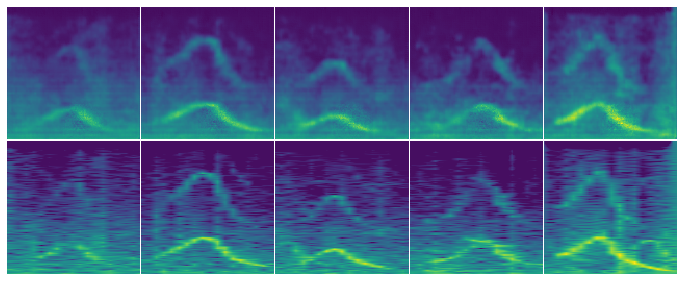

In [160]:
%matplotlib inline


indices = np.random.choice(np.arange(len(dl.dataset)), size=5 ,replace=False)
specs = torch.stack([dl.dataset[ind] for ind in indices]).to(model.device)
# Get resonstructions.
with torch.no_grad():
    _, _, rec_specs = model.forward(specs, return_latent_rec=True)
    specs = specs.detach().cpu().numpy()
    all_specs = np.stack([specs, rec_specs])
    grid_plot(all_specs, gap=1, filename='save_filename')
 

In [155]:
from src.audiodata_processing.process_waves import denoise_recording


recs_dict_denoised = {}
for rec_name, rec in recs_dict.items():
    recs_dict_denoised[rec_name] = denoise_recording(rec, sr, **rec_denoising_params)

Process LokyProcess-21:
Traceback (most recent call last):
  File "/home/gr1/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gr1/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gr1/miniconda3/envs/pytorch/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.collect()
KeyboardInterrupt
Process LokyProcess-32:
Traceback (most recent call last):
  File "/home/gr1/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/gr1/miniconda3/envs/pytorch/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/gr1/miniconda3/envs/pytorch/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.collect()
Ke

KeyboardInterrupt: 

In [ ]:
specs_denoised = create_specs_new(sounds_metadata_train, recs_dict_denoised, spec_params, sr=22050)

In [99]:
dl = DataLoader(data, batch_size=1, shuffle=False, sampler=None,)
latent_features = model.get_latent(dl)
latend_features_scaled = StandardScaler().fit_transform(latent_features)

In [123]:
import umap
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [164]:
mask = np.ones(len(sounds_metadata_train), dtype='bool')
mask *= ~sounds_metadata_train['cl'].isin(['softchirp'])


features = latent_features[mask]
sounds_metadata_to_use = sounds_metadata_train[mask].reset_index(drop=True)

In [176]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=128)


In [173]:
transform = umap.UMAP(n_components=2, n_neighbors=2, min_dist=0.5, metric='euclidean', random_state=42)
#transform = TSNE(n_components=2)
projection_2d = transform.fit_transform(features)

/home/gr1/miniconda3/envs/pytorch/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


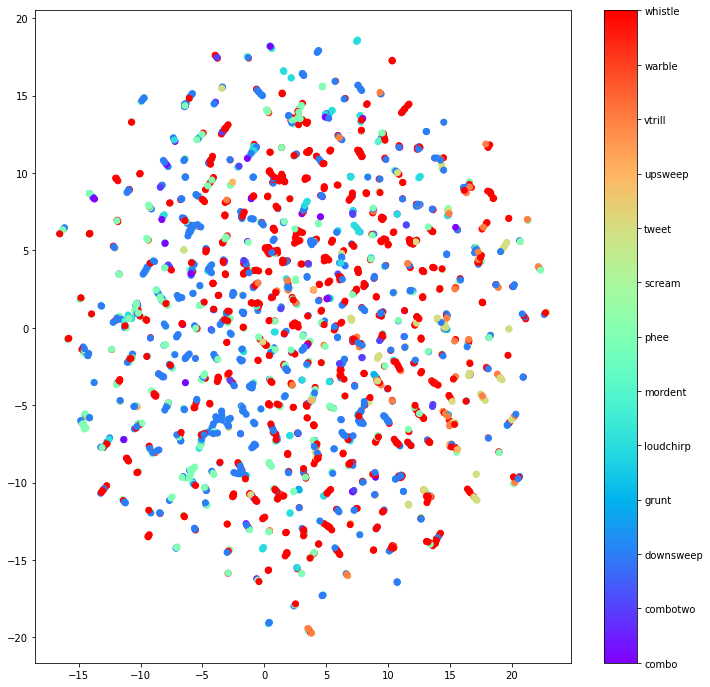

In [174]:
y_unique = sorted(list(sounds_metadata_to_use['cl'].unique()))
c = [y_unique.index(yi) for yi in sounds_metadata_to_use['cl']]

plt.figure(figsize=(12, 12))
ticks = np.arange(0, len(y_unique))
cmap = cm.rainbow
plt.scatter(projection_2d[:, 0], projection_2d[:, 1], c=c, cmap=cmap)
cbar = plt.colorbar(ticks = ticks)
_ = cbar.ax.set_yticklabels(y_unique)

In [74]:
def grid_plot(specs, gap=3, vmin=0.0, vmax=1.0, ax=None, save_and_close=False, filename='temp.pdf'):
    plt.figure(figsize=(12, 12))
    if type(gap) == type(4):
        gap = (gap,gap)
    try:
        a, b, c, d = specs.shape
    except:
        print("Invalid shape:", specs.shape, "Should have 4 dimensions.")
        quit()
    dx, dy = d+gap[1], c+gap[0]
    height = a*c + (a-1)*gap[0]
    width = b*d + (b-1)*gap[1]
    img = np.zeros((height, width))
    for j in range(a):
        for i in range(b):
            img[j*dy:j*dy+c,i*dx:i*dx+d] = specs[-j-1,i]
    for i in range(1,b):
        img[:,i*dx-gap[1]:i*dx] = np.nan
    for j in range(1,a):
        img[j*dy-gap[0]:j*dy,:] = np.nan
    if ax is None:
        ax = plt.gca()
    ax.imshow(img, aspect='equal', interpolation='none', )
    ax.axis('off')
    if save_and_close:
        plt.tight_layout()
        #plt.savefig(filename)
        plt.close('all')